In [1]:
import torch
import os
import sys
import numpy as np
print(torch.cuda.is_available())
np.random.seed(42)
torch.manual_seed(42)
os.environ["PYTHONHASHSEED"] = "42"
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_num_threads(1)
# device = torch.device("cpu")
# Read model serialize/pt file
serialized_file = "models/megadetectorv5/md_v5a.0.0.pt"

# Model
model = torch.hub.load('/root/.cache/torch/hub/ultralytics_yolov5_master', 'custom', source = "local", skip_validation=True, path=serialized_file) 

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


YOLOv5 🚀 2022-12-12 Python-3.9.13 torch-1.10.0+cu102 CPU

Fusing layers... 
Model summary: 574 layers, 139990096 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


In [2]:
from ts.torch_handler.base_handler import BaseHandler
import numpy as np
import cv2
import base64
import torch
import torchvision.transforms as tf
import torchvision
import io
from PIL import Image

img_size = 1280
min_conf_thresh = 0.00001


def preprocess(img_path):
    """Converts input images to float tensors.
    Args:
        data (List): Input data from the request in the form of a list of image tensors.
    Returns:
        Tensor: single Tensor of shape [BATCH_SIZE=1, 3, IMG_SIZE, IMG_SIZE]
    """
    image = load_image(img_path)

    
    # force convert to tensor
    # and resize to [img_size, img_size]
    image = np.asarray(image)
    image = letterbox(image, new_shape=img_size,
                stride=64, auto=True)[0]  # JIT requires auto=False\
    image = image.transpose((2, 0, 1))  # HWC to CHW; PIL Image is RGB already
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    # image = image.to(self.device)
    image = image.float()
    image /= 255
    image = torch.unsqueeze(image, 0)
    # has shape BATCH_SIZE=1 x 3 x IMG_SIZE x IMG_SIZE
    print(image.shape)
    print(type(image))

    return image

def postprocess(inference_output):
    # perform NMS (nonmax suppression) on model outputs
    pred = non_max_suppression(inference_output, conf_thres=min_conf_thresh, iou_thres=.45)

    # initialize empty list of detections for each image
    detections = [[] for _ in range(len(pred))]

    for i, image_detections in enumerate(pred):  # axis 0: for each image
        for det in image_detections:  # axis 1: for each detection
            # x1,y1,x2,y2 in normalized image coordinates (i.e. 0.0-1.0)
            xyxy = det[:4] / img_size
            # confidence value
            conf = det[4].item()
            # index of predicted class
            class_idx = int(det[5].item())
            detections[i].append({
                "x1": xyxy[0].item(),
                "y1": xyxy[1].item(),
                "x2": xyxy[2].item(),
                "y2": xyxy[3].item(),
                "confidence": conf,
                "class": class_idx + 1 # schema we use is 1 for animal, 2 for person, 3 for vehicle
            })

    # format each detection
    return detections


def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                    labels=(), max_det=1000):
    """Runs Non-Maximum Suppression (NMS) on inference results
    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    # (pixels) minimum and maximum box width and height
    min_wh, max_wh = 2, 4096
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    output = [torch.zeros((0, 6), device=prediction.device)
              ] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[
                conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            # sort by confidence
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = torchvision.box_iou(
                boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float(
            ) / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]

    return output


def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    print("shape start: ", shape)
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)
        print("new shape: ", new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)
    print("r: ", r)
    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    print("new_unpad 1: ", new_unpad)
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2
    print("new_unpad 2: ", new_unpad)
    print("shape: ", shape)
    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    print("top: ", top)
    print("bottom: ", bottom)
    print("left", left)
    print("right", right)
    return im, ratio, (dw, dh)

def open_image(input_file):
    """
    Opens an image in binary format using PIL.Image and converts to RGB mode.

    Supports local files or URLs.
    This operation is lazy; image will not be actually loaded until the first
    operation that needs to load it (for example, resizing), so file opening
    errors can show up later.
    Args:
        input_file: str or BytesIO, either a path to an image file (anything
            that PIL can open), or an image as a stream of bytes
    Returns:
        an PIL image object in RGB mode
    """
    if (isinstance(input_file, str)
            and input_file.startswith(('http://', 'https://'))):
        try:
            response = requests.get(input_file)
        except Exception as e:
            print(f'Error retrieving image {input_file}: {e}')
            success = False
            if e.__class__.__name__ in error_names_for_retry:
                for i_retry in range(0,n_retries):
                    try:
                        time.sleep(retry_sleep_time)
                        response = requests.get(input_file)        
                    except Exception as e:
                        print(f'Error retrieving image {input_file} on retry {i_retry}: {e}')
                        continue
                    print('Succeeded on retry {}'.format(i_retry))
                    success = True
                    break
            if not success:
                raise
        try:
            image = Image.open(BytesIO(response.content))
        except Exception as e:
            print(f'Error opening image {input_file}: {e}')
            raise

    else:
        image = Image.open(input_file)
    if image.mode not in ('RGBA', 'RGB', 'L', 'I;16'):
        raise AttributeError(
            f'Image {input_file} uses unsupported mode {image.mode}')
    if image.mode == 'RGBA' or image.mode == 'L':
        # PIL.Image.convert() returns a converted copy of this image
        image = image.convert(mode='RGB')

    # Alter orientation as needed according to EXIF tag 0x112 (274) for Orientation
    #
    # https://gist.github.com/dangtrinhnt/a577ece4cbe5364aad28
    # https://www.media.mit.edu/pia/Research/deepview/exif.html
    #
    try:
        exif = image._getexif()
        orientation: int = exif.get(274, None)  # 274 is the key for the Orientation field
        if orientation is not None and orientation in IMAGE_ROTATIONS:
            image = image.rotate(IMAGE_ROTATIONS[orientation], expand=True)  # returns a rotated copy
    except Exception:
        pass

    return image


def load_image(input_file):
    """
    Loads the image at input_file as a PIL Image into memory.
    Image.open() used in open_image() is lazy and errors will occur downstream
    if not explicitly loaded.
    Args:
        input_file: str or BytesIO, either a path to an image file (anything
            that PIL can open), or an image as a stream of bytes
    Returns: PIL.Image.Image, in RGB mode
    """
    image = open_image(input_file)
    image.load()
    return image

In [3]:
false_negs = '../../input/md-rodent-false-negatives/'

In [4]:
from pathlib import Path

fnegs_dir = Path(false_negs)

In [5]:
imgs = [str(i) for i in fnegs_dir.glob("**/*.jpg")]

In [6]:
results = {}
for pth in imgs:
    im = preprocess(pth)
    result = model.forward(im)
    results.update({pth.split("/")[-1]:postprocess(result)})

shape start:  (900, 1600)
new shape:  (1280, 1280)
r:  0.8
new_unpad 1:  (1280, 720)
new_unpad 2:  (1280, 720)
shape:  (900, 1600)
top:  24
bottom:  24
left 0
right 0
torch.Size([1, 3, 768, 1280])
<class 'torch.Tensor'>
shape start:  (900, 1600)
new shape:  (1280, 1280)
r:  0.8
new_unpad 1:  (1280, 720)
new_unpad 2:  (1280, 720)
shape:  (900, 1600)
top:  24
bottom:  24
left 0
right 0
torch.Size([1, 3, 768, 1280])
<class 'torch.Tensor'>
shape start:  (900, 1600)
new shape:  (1280, 1280)
r:  0.8
new_unpad 1:  (1280, 720)
new_unpad 2:  (1280, 720)
shape:  (900, 1600)
top:  24
bottom:  24
left 0
right 0
torch.Size([1, 3, 768, 1280])
<class 'torch.Tensor'>
shape start:  (900, 1600)
new shape:  (1280, 1280)
r:  0.8
new_unpad 1:  (1280, 720)
new_unpad 2:  (1280, 720)
shape:  (900, 1600)
top:  24
bottom:  24
left 0
right 0
torch.Size([1, 3, 768, 1280])
<class 'torch.Tensor'>
shape start:  (900, 1600)
new shape:  (1280, 1280)
r:  0.8
new_unpad 1:  (1280, 720)
new_unpad 2:  (1280, 720)
shape:  (

In [7]:
top_results = {}
for k,v in results.items():
    top_results.update({k: v[0][0]})

In [8]:
{
 "images": [
  {
   "file": "X811492D/p_004854_6e1065060487c8d74231cfc4e66ac404.jpg",
   "max_detection_conf": 0.226,
   "detections": [
    {
     "category": "3",
     "conf": 0.0154,
     "bbox": [
      0,
      0,
      0.9984,
      1.0
     ]
    },
    {
     "category": "1",
     "conf": 0.0277,
     "bbox": [
      0.9539,
      0.5,
      0.04609,
      0.0302
     ]
    },
    {
     "category": "1",
     "conf": 0.226,
     "bbox": [
      0.5656,
      0.4083,
      0.02734,
      0.04895
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005716_eeeb4c32efe999c21185c2bc4e3ec26a.jpg",
   "max_detection_conf": 0.721,
   "detections": [
    {
     "category": "1",
     "conf": 0.00986,
     "bbox": [
      0.1351,
      0.427,
      0.04765,
      0.05624
     ]
    },
    {
     "category": "1",
     "conf": 0.0187,
     "bbox": [
      0.1601,
      0.4354,
      0.07265,
      0.07708
     ]
    },
    {
     "category": "1",
     "conf": 0.622,
     "bbox": [
      0.08437,
      0.427,
      0.09531,
      0.06041
     ]
    },
    {
     "category": "1",
     "conf": 0.721,
     "bbox": [
      0.1593,
      0.4364,
      0.1484,
      0.09062
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005711_31c84c08435e63dbd2be57074c0d89c3.jpg",
   "max_detection_conf": 0.374,
   "detections": [
    {
     "category": "1",
     "conf": 0.0142,
     "bbox": [
      0.3367,
      0.5437,
      0.08828,
      0.07708
     ]
    },
    {
     "category": "1",
     "conf": 0.0207,
     "bbox": [
      0.1531,
      0.3208,
      0.05937,
      0.0302
     ]
    },
    {
     "category": "1",
     "conf": 0.1,
     "bbox": [
      0.1625,
      0.4375,
      0.1429,
      0.08437
     ]
    },
    {
     "category": "1",
     "conf": 0.374,
     "bbox": [
      0.3367,
      0.5593,
      0.04921,
      0.06041
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005740_a2d80bb23f76bf0ba5c798763cb0b621.jpg",
   "max_detection_conf": 0.827,
   "detections": [
    {
     "category": "1",
     "conf": 0.827,
     "bbox": [
      0.5648,
      0.3729,
      0.04453,
      0.07708
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_004867_a0369fd98e35ba25938ab469f4a77570.jpg",
   "max_detection_conf": 0.614,
   "detections": [
    {
     "category": "1",
     "conf": 0.0305,
     "bbox": [
      0.371,
      0.5156,
      0.1304,
      0.06041
     ]
    },
    {
     "category": "1",
     "conf": 0.614,
     "bbox": [
      0.4242,
      0.5291,
      0.07734,
      0.04895
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_006129_b3766ecf0cf81cb92ca4a86dbcbe7951.jpg",
   "max_detection_conf": 0.8,
   "detections": [
    {
     "category": "1",
     "conf": 0.00659,
     "bbox": [
      0.3507,
      0.4145,
      0.05624,
      0.2343
     ]
    },
    {
     "category": "1",
     "conf": 0.8,
     "bbox": [
      0.3546,
      0.5385,
      0.05156,
      0.1083
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_004868_1226b2b388ce14b2eaa9a8173f997076.jpg",
   "max_detection_conf": 0.766,
   "detections": [
    {
     "category": "1",
     "conf": 0.00518,
     "bbox": [
      0.9554,
      0.5,
      0.04453,
      0.06979
     ]
    },
    {
     "category": "1",
     "conf": 0.00812,
     "bbox": [
      0.9554,
      0.4677,
      0.04453,
      0.0625
     ]
    },
    {
     "category": "1",
     "conf": 0.0368,
     "bbox": [
      0.2453,
      0.5312,
      0.06875,
      0.06562
     ]
    },
    {
     "category": "1",
     "conf": 0.0846,
     "bbox": [
      0.9554,
      0.502,
      0.04453,
      0.03125
     ]
    },
    {
     "category": "1",
     "conf": 0.766,
     "bbox": [
      0.2445,
      0.5124,
      0.1367,
      0.08437
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005917_c4bbea2508aa55781aa447a258730c9e.jpg",
   "max_detection_conf": 0.464,
   "detections": [
    {
     "category": "1",
     "conf": 0.0298,
     "bbox": [
      0.4546,
      0.5093,
      0.07343,
      0.1072
     ]
    },
    {
     "category": "1",
     "conf": 0.464,
     "bbox": [
      0.4554,
      0.527,
      0.03906,
      0.09166
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005023_c4835eec9e39b83b03ef7a2e072812fc.jpg",
   "max_detection_conf": 0.582,
   "detections": [
    {
     "category": "1",
     "conf": 0.00516,
     "bbox": [
      0.7625,
      0.5062,
      0.1906,
      0.1562
     ]
    },
    {
     "category": "3",
     "conf": 0.582,
     "bbox": [
      0,
      0.001041,
      1.0,
      0.6135
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005019_a834047dce70aa1f3cd97b5c777c9e38.jpg",
   "max_detection_conf": 0.419,
   "detections": [
    {
     "category": "1",
     "conf": 0.00757,
     "bbox": [
      0.5085,
      0.4531,
      0.05703,
      0.04166
     ]
    },
    {
     "category": "3",
     "conf": 0.419,
     "bbox": [
      0,
      0,
      1.0,
      0.5937
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005758_2c31e013c27e25b1031679aca1ea8699.jpg",
   "max_detection_conf": 0.886,
   "detections": [
    {
     "category": "1",
     "conf": 0.886,
     "bbox": [
      0.4039,
      0.5812,
      0.0539,
      0.1031
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005743_6a0d68c8e80484a83b4b79ffa21f0aff.jpg",
   "max_detection_conf": 0.769,
   "detections": [
    {
     "category": "1",
     "conf": 0.769,
     "bbox": [
      0.3593,
      0.5906,
      0.075,
      0.09375
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005709_7afa387d125dca1dda745a525eb99646.jpg",
   "max_detection_conf": 0.335,
   "detections": [
    {
     "category": "1",
     "conf": 0.00866,
     "bbox": [
      0.7374,
      0.4802,
      0.1414,
      0.04895
     ]
    },
    {
     "category": "3",
     "conf": 0.014,
     "bbox": [
      0,
      0,
      1.0,
      1.0
     ]
    },
    {
     "category": "1",
     "conf": 0.0155,
     "bbox": [
      0.164,
      0.4375,
      0.1398,
      0.08958
     ]
    },
    {
     "category": "1",
     "conf": 0.335,
     "bbox": [
      0.7374,
      0.4802,
      0.07343,
      0.03333
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_004855_9560691befb39fa85d573b1fc5e716bc.jpg",
   "max_detection_conf": 0.0165,
   "detections": [
    {
     "category": "3",
     "conf": 0.0165,
     "bbox": [
      0.0007812,
      0.001041,
      0.9992,
      0.5885
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005920_cdce3e53ad6b8c7fc4e0d73d2441a97e.jpg",
   "max_detection_conf": 0.107,
   "detections": [
    {
     "category": "1",
     "conf": 0.0056,
     "bbox": [
      0.4703,
      0.577,
      0.06796,
      0.06979
     ]
    },
    {
     "category": "1",
     "conf": 0.0317,
     "bbox": [
      0.4835,
      0.5791,
      0.1023,
      0.08958
     ]
    },
    {
     "category": "3",
     "conf": 0.107,
     "bbox": [
      0,
      0,
      1.0,
      0.5989
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_006128_ee6c4908be0c094e87af1c3d17742203.jpg",
   "max_detection_conf": 0.399,
   "detections": [
    {
     "category": "3",
     "conf": 0.399,
     "bbox": [
      0.0007812,
      0.001041,
      0.9992,
      0.6312
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005678_e981fe9a29bbb6c8e83473a55acd7124.jpg",
   "max_detection_conf": 0.921,
   "detections": [
    {
     "category": "1",
     "conf": 0.921,
     "bbox": [
      0.4632,
      0.4656,
      0.1031,
      0.07916
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005776_163d627966fa5484e0403643d691cc71.jpg",
   "max_detection_conf": 0.862,
   "detections": [
    {
     "category": "1",
     "conf": 0.00506,
     "bbox": [
      0,
      0.8781,
      0.01953,
      0.09687
     ]
    },
    {
     "category": "3",
     "conf": 0.0118,
     "bbox": [
      0.0007812,
      0,
      0.9992,
      0.5749
     ]
    },
    {
     "category": "1",
     "conf": 0.862,
     "bbox": [
      0,
      0.8229,
      0.06093,
      0.151
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005153_5d43ba430076ee466053ad1cda44e1f6.jpg",
   "max_detection_conf": 0.0589,
   "detections": [
    {
     "category": "3",
     "conf": 0.0209,
     "bbox": [
      0.0007812,
      0.001041,
      0.9992,
      0.5854
     ]
    },
    {
     "category": "2",
     "conf": 0.0589,
     "bbox": [
      0,
      0.002083,
      0.221,
      0.8583
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_004856_527f5e292316d5214f6fd87626a2e44d.jpg",
   "max_detection_conf": 0.872,
   "detections": [
    {
     "category": "1",
     "conf": 0.00591,
     "bbox": [
      0.9546,
      0.5,
      0.04531,
      0.03125
     ]
    },
    {
     "category": "1",
     "conf": 0.00913,
     "bbox": [
      0.5054,
      0.4489,
      0.04296,
      0.04687
     ]
    },
    {
     "category": "1",
     "conf": 0.872,
     "bbox": [
      0.5062,
      0.4416,
      0.07734,
      0.05624
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005025_7dcd9f84b5cb3e1618a896a0b72b4637.jpg",
   "max_detection_conf": 0.0525,
   "detections": [
    {
     "category": "3",
     "conf": 0.0525,
     "bbox": [
      0.001562,
      0.001041,
      0.9984,
      0.5843
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005922_c031793dd86a5972e61721748ea0d9ad.jpg",
   "max_detection_conf": 0.15,
   "detections": [
    {
     "category": "3",
     "conf": 0.145,
     "bbox": [
      0.0007812,
      0.001041,
      0.9984,
      0.5666
     ]
    },
    {
     "category": "1",
     "conf": 0.15,
     "bbox": [
      0.3179,
      0.4125,
      0.07968,
      0.06875
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_004859_fb03adbdedc0b08ec59c0c4a677bae76.jpg",
   "max_detection_conf": 0.735,
   "detections": [
    {
     "category": "1",
     "conf": 0.00694,
     "bbox": [
      0.9562,
      0.5031,
      0.04374,
      0.03125
     ]
    },
    {
     "category": "1",
     "conf": 0.0357,
     "bbox": [
      0.5171,
      0.4718,
      0.07968,
      0.04687
     ]
    },
    {
     "category": "1",
     "conf": 0.735,
     "bbox": [
      0.4789,
      0.4479,
      0.1187,
      0.06979
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005715_15583a8237821f53cd7c306ad2baefe1.jpg",
   "max_detection_conf": 0.788,
   "detections": [
    {
     "category": "1",
     "conf": 0.00638,
     "bbox": [
      0.164,
      0.4291,
      0.0664,
      0.08541
     ]
    },
    {
     "category": "3",
     "conf": 0.00675,
     "bbox": [
      0.002343,
      0,
      0.9976,
      1.0
     ]
    },
    {
     "category": "1",
     "conf": 0.0263,
     "bbox": [
      0.164,
      0.4281,
      0.1414,
      0.09583
     ]
    },
    {
     "category": "1",
     "conf": 0.788,
     "bbox": [
      0.06875,
      0.4281,
      0.1085,
      0.0552
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_004863_483375a320c8f6a00c0a22da32ae6eee.jpg",
   "max_detection_conf": 0.845,
   "detections": [
    {
     "category": "1",
     "conf": 0.0163,
     "bbox": [
      0.1078,
      0.4802,
      0.05078,
      0.03958
     ]
    },
    {
     "category": "1",
     "conf": 0.845,
     "bbox": [
      0.1078,
      0.4802,
      0.09843,
      0.04583
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005742_1d80f68cc6bbea67ff24d183e5967467.jpg",
   "max_detection_conf": 0.639,
   "detections": [
    {
     "category": "1",
     "conf": 0.00971,
     "bbox": [
      0.3281,
      0.5885,
      0.08749,
      0.09687
     ]
    },
    {
     "category": "1",
     "conf": 0.639,
     "bbox": [
      0.3601,
      0.5749,
      0.09062,
      0.1114
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_006012_c45df9b0160498b74b8e9ef86dc0407a.jpg",
   "max_detection_conf": 0.322,
   "detections": [
    {
     "category": "2",
     "conf": 0.00588,
     "bbox": [
      0,
      0,
      0.2312,
      0.6708
     ]
    },
    {
     "category": "1",
     "conf": 0.0169,
     "bbox": [
      0.2351,
      0.4406,
      0.0664,
      0.05416
     ]
    },
    {
     "category": "3",
     "conf": 0.297,
     "bbox": [
      0.0007812,
      0.001041,
      0.9984,
      0.5874
     ]
    },
    {
     "category": "1",
     "conf": 0.322,
     "bbox": [
      0.2343,
      0.427,
      0.1164,
      0.06875
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005021_89b955d2dc69efa2666fc32d41d56ccd.jpg",
   "max_detection_conf": 0.705,
   "detections": [
    {
     "category": "1",
     "conf": 0.0387,
     "bbox": [
      0.2492,
      0.4572,
      0.06171,
      0.04479
     ]
    },
    {
     "category": "3",
     "conf": 0.334,
     "bbox": [
      0,
      0,
      1.0,
      0.6072
     ]
    },
    {
     "category": "1",
     "conf": 0.705,
     "bbox": [
      0.2492,
      0.4427,
      0.1195,
      0.06041
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_004865_5dd177fdbea13f1ef2810ecc391510f2.jpg",
   "max_detection_conf": 0.534,
   "detections": [
    {
     "category": "1",
     "conf": 0.0296,
     "bbox": [
      0.4507,
      0.526,
      0.05078,
      0.04895
     ]
    },
    {
     "category": "1",
     "conf": 0.534,
     "bbox": [
      0.4164,
      0.5135,
      0.08593,
      0.06666
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_004853_5761994d784a1f7b5fec4ec08e268f3f.jpg",
   "max_detection_conf": 0.796,
   "detections": [
    {
     "category": "3",
     "conf": 0.0094,
     "bbox": [
      0,
      0.005208,
      1.0,
      0.9947
     ]
    },
    {
     "category": "1",
     "conf": 0.0328,
     "bbox": [
      0.9546,
      0.4989,
      0.04531,
      0.03125
     ]
    },
    {
     "category": "1",
     "conf": 0.796,
     "bbox": [
      0.4695,
      0.4427,
      0.1046,
      0.04895
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005020_d0686ef7020a94d2ae743adb1649f7d2.jpg",
   "max_detection_conf": 0.432,
   "detections": [
    {
     "category": "1",
     "conf": 0.14,
     "bbox": [
      0.5164,
      0.4572,
      0.05312,
      0.03854
     ]
    },
    {
     "category": "3",
     "conf": 0.432,
     "bbox": [
      0,
      0.001041,
      1.0,
      0.6156
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005018_4b0298f301c2a5bad8638def9c87b62d.jpg",
   "max_detection_conf": 0.306,
   "detections": [
    {
     "category": "1",
     "conf": 0.0624,
     "bbox": [
      0.5132,
      0.4562,
      0.05624,
      0.03958
     ]
    },
    {
     "category": "3",
     "conf": 0.306,
     "bbox": [
      0.0007812,
      0.001041,
      0.9992,
      0.5781
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005676_a7adba933fa984bdb765f95044bc5bc8.jpg",
   "max_detection_conf": 0.878,
   "detections": [
    {
     "category": "1",
     "conf": 0.878,
     "bbox": [
      0.4765,
      0.4749,
      0.07812,
      0.08333
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005155_4b6e6cfbcae81b7aab6ae8e8d4c66fec.jpg",
   "max_detection_conf": 0.0436,
   "detections": [
    {
     "category": "2",
     "conf": 0.00628,
     "bbox": [
      0,
      0,
      0.2328,
      0.8333
     ]
    },
    {
     "category": "3",
     "conf": 0.0199,
     "bbox": [
      0,
      0,
      1.0,
      0.877
     ]
    },
    {
     "category": "2",
     "conf": 0.0436,
     "bbox": [
      0,
      0,
      1.0,
      0.8739
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005757_883c5a67c6b241a3392b5b8cda059558.jpg",
   "max_detection_conf": 0.89,
   "detections": [
    {
     "category": "1",
     "conf": 0.89,
     "bbox": [
      0.4023,
      0.5802,
      0.0539,
      0.1052
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005022_dfe14b581273494ef65e7656c3d5f5dc.jpg",
   "max_detection_conf": 0.509,
   "detections": [
    {
     "category": "1",
     "conf": 0.0155,
     "bbox": [
      0.114,
      0.4458,
      0.03906,
      0.04374
     ]
    },
    {
     "category": "3",
     "conf": 0.509,
     "bbox": [
      0,
      0,
      1.0,
      0.577
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005766_6470586fa4dca0be0c9d584d4c5b64ff.jpg",
   "max_detection_conf": 0.554,
   "detections": [
    {
     "category": "1",
     "conf": 0.0549,
     "bbox": [
      0.1835,
      0.3322,
      0.05703,
      0.1822
     ]
    },
    {
     "category": "1",
     "conf": 0.554,
     "bbox": [
      0.1851,
      0.4458,
      0.05546,
      0.06875
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005718_c7e5c16073715515ada660f73a078c81.jpg",
   "max_detection_conf": 0.266,
   "detections": [
    {
     "category": "3",
     "conf": 0.00538,
     "bbox": [
      0,
      0,
      1.0,
      1.0
     ]
    },
    {
     "category": "1",
     "conf": 0.00568,
     "bbox": [
      0.1562,
      0.3208,
      0.05468,
      0.03125
     ]
    },
    {
     "category": "1",
     "conf": 0.00576,
     "bbox": [
      0.1374,
      0.4249,
      0.03984,
      0.02187
     ]
    },
    {
     "category": "1",
     "conf": 0.266,
     "bbox": [
      0.1617,
      0.4354,
      0.1445,
      0.09791
     ]
    }
   ]
  },
  {
   "file": "X811492D/p_005203_2da0d1b0b813be06fba42dd7f4c9dcfd.jpg",
   "max_detection_conf": 0.0679,
   "detections": [
    {
     "category": "1",
     "conf": 0.00578,
     "bbox": [
      0.6921,
      0.5197,
      0.06171,
      0.06145
     ]
    },
    {
     "category": "1",
     "conf": 0.0106,
     "bbox": [
      0.1078,
      0.4541,
      0.0125,
      0.01354
     ]
    },
    {
     "category": "3",
     "conf": 0.0116,
     "bbox": [
      0,
      0.001041,
      1.0,
      0.5781
     ]
    },
    {
     "category": "1",
     "conf": 0.0679,
     "bbox": [
      0.1085,
      0.4416,
      0.05703,
      0.0375
     ]
    }
   ]
  },
  {
   "file": "X8114819/p_008645_704203c9623121c81d05700b0dc1a508.jpg",
   "max_detection_conf": 0.893,
   "detections": [
    {
     "category": "1",
     "conf": 0.893,
     "bbox": [
      0.4054,
      0.5416,
      0.04062,
      0.1406
     ]
    }
   ]
  },
  {
   "file": "X8114819/p_008828_0ec11fd8bf0fce589b7f25fc6584484e.jpg",
   "max_detection_conf": 0.852,
   "detections": [
    {
     "category": "1",
     "conf": 0.852,
     "bbox": [
      0.2804,
      0.4812,
      0.09375,
      0.05416
     ]
    }
   ]
  },
  {
   "file": "X8114819/p_008560_0bb1291e74636ce14442ff478f390c0e.jpg",
   "max_detection_conf": 0.604,
   "detections": [
    {
     "category": "1",
     "conf": 0.00572,
     "bbox": [
      0.3484,
      0.8166,
      0.08593,
      0.06979
     ]
    },
    {
     "category": "1",
     "conf": 0.0115,
     "bbox": [
      0.1789,
      0.1208,
      0.03984,
      0.04895
     ]
    },
    {
     "category": "1",
     "conf": 0.0239,
     "bbox": [
      0.1945,
      0.1249,
      0.03281,
      0.06145
     ]
    },
    {
     "category": "1",
     "conf": 0.0313,
     "bbox": [
      0.1968,
      0.1249,
      0.02109,
      0.02187
     ]
    },
    {
     "category": "1",
     "conf": 0.604,
     "bbox": [
      0.1968,
      0.1239,
      0.04374,
      0.1302
     ]
    }
   ]
  },
  {
   "file": "X8114819/p_008559_50574db52081948d8164ed726e1e88da.jpg",
   "max_detection_conf": 0.0121,
   "detections": [
    {
     "category": "1",
     "conf": 0.00576,
     "bbox": [
      0.2898,
      0.351,
      0.03359,
      0.1104
     ]
    },
    {
     "category": "1",
     "conf": 0.0121,
     "bbox": [
      0.3476,
      0.8177,
      0.08749,
      0.06458
     ]
    }
   ]
  },
  {
   "file": "X8114819/p_008830_927e8478404ba189178e0a43c1d446a2.jpg",
   "max_detection_conf": 0.872,
   "detections": [
    {
     "category": "1",
     "conf": 0.872,
     "bbox": [
      0.4695,
      0.3135,
      0.04062,
      0.1291
     ]
    }
   ]
  },
  {
   "file": "X8114819/p_008813_a647da3b39845471d5a0d3e4d588bcdc.jpg",
   "max_detection_conf": 0.0,
   "detections": []
  },
  {
   "file": "X8114819/p_008812_5f2623abe3da1c97aafc2a4821b88b6c.jpg",
   "max_detection_conf": 0.74,
   "detections": [
    {
     "category": "1",
     "conf": 0.74,
     "bbox": [
      0.271,
      0.3968,
      0.04531,
      0.1145
     ]
    }
   ]
  },
  {
   "file": "X8114566/p_000531_470b3f041f4f1e8d7e138b24f844866e.jpg",
   "max_detection_conf": 0.052,
   "detections": [
    {
     "category": "1",
     "conf": 0.052,
     "bbox": [
      0.8281,
      0.4283,
      0.1523,
      0.09895
     ]
    }
   ]
  },
  {
   "file": "X8114566/p_000530_d15069f391e85900ef46cbefc62184cc.jpg",
   "max_detection_conf": 0.8,
   "detections": [
    {
     "category": "1",
     "conf": 0.0207,
     "bbox": [
      0.9418,
      0.1595,
      0.0581,
      0.11
     ]
    },
    {
     "category": "1",
     "conf": 0.0321,
     "bbox": [
      0.8247,
      0.4283,
      0.1562,
      0.1015
     ]
    },
    {
     "category": "1",
     "conf": 0.8,
     "bbox": [
      0.414,
      0.4934,
      0.06103,
      0.1191
     ]
    }
   ]
  },
  {
   "file": "X8114566/p_000532_d25f5ae5833e37c06601f71dfcd5b359.jpg",
   "max_detection_conf": 0.215,
   "detections": [
    {
     "category": "1",
     "conf": 0.0111,
     "bbox": [
      0.9404,
      0.1562,
      0.05957,
      0.1119
     ]
    },
    {
     "category": "1",
     "conf": 0.0209,
     "bbox": [
      0.5366,
      0.4667,
      0.07519,
      0.08593
     ]
    },
    {
     "category": "1",
     "conf": 0.0248,
     "bbox": [
      0.5375,
      0.4921,
      0.05908,
      0.1009
     ]
    },
    {
     "category": "1",
     "conf": 0.0714,
     "bbox": [
      0.8339,
      0.4277,
      0.1469,
      0.1028
     ]
    },
    {
     "category": "1",
     "conf": 0.215,
     "bbox": [
      0.538,
      0.4921,
      0.04736,
      0.05664
     ]
    }
   ]
  },
  {
   "file": "864839046686982/40770611_377da70ea6314b41640ed9e8b205a8bc.jpg",
   "max_detection_conf": 0.835,
   "detections": [
    {
     "category": "1",
     "conf": 0.835,
     "bbox": [
      0.7981,
      0.3222,
      0.04187,
      0.1
     ]
    }
   ]
  },
  {
   "file": "864839046686982/40770364_2413174b7edf43108365e6d29ae9d2c6.jpg",
   "max_detection_conf": 0.88,
   "detections": [
    {
     "category": "1",
     "conf": 0.88,
     "bbox": [
      0.6812,
      0.2588,
      0.0375,
      0.1555
     ]
    }
   ]
  },
  {
   "file": "864839046686982/41714236_1732620ae49d990517e59e71db99161b.jpg",
   "max_detection_conf": 0.897,
   "detections": [
    {
     "category": "1",
     "conf": 0.897,
     "bbox": [
      0.71,
      0.2211,
      0.05999,
      0.1788
     ]
    }
   ]
  },
  {
   "file": "864839046686982/41714241_34cf842e15b2a7a67cca5f0c6cc87d83.jpg",
   "max_detection_conf": 0.919,
   "detections": [
    {
     "category": "1",
     "conf": 0.919,
     "bbox": [
      0.7099,
      0.2122,
      0.0575,
      0.1855
     ]
    }
   ]
  },
  {
   "file": "864839046686982/42130768_db76ac6171aee2550fe72f7b684a58f0.jpg",
   "max_detection_conf": 0.941,
   "detections": [
    {
     "category": "1",
     "conf": 0.941,
     "bbox": [
      0.3943,
      0.24,
      0.04562,
      0.1833
     ]
    }
   ]
  },
  {
   "file": "864839046686982/41692583_89a961fc5c3ab4df39c89b4de40b2ef5.jpg",
   "max_detection_conf": 0.858,
   "detections": [
    {
     "category": "1",
     "conf": 0.858,
     "bbox": [
      0.7206,
      0.2077,
      0.03812,
      0.1777
     ]
    }
   ]
  },
  {
   "file": "864839046686982/40684101_a2514f39ba853391e5248ab18f36945e.jpg",
   "max_detection_conf": 0.922,
   "detections": [
    {
     "category": "1",
     "conf": 0.922,
     "bbox": [
      0.7499,
      0.2666,
      0.045,
      0.1555
     ]
    }
   ]
  },
  {
   "file": "864839046686982/41692563_936638af3dc4ca9aa5068142f69b2191.jpg",
   "max_detection_conf": 0.867,
   "detections": [
    {
     "category": "1",
     "conf": 0.867,
     "bbox": [
      0.7212,
      0.2011,
      0.03812,
      0.1844
     ]
    }
   ]
  },
  {
   "file": "864839046686982/42130742_e8ee9e1c2cbd75da91a1ce12f9277b74.jpg",
   "max_detection_conf": 0.935,
   "detections": [
    {
     "category": "1",
     "conf": 0.935,
     "bbox": [
      0.3962,
      0.2399,
      0.04625,
      0.1888
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004718_564d6076787a1f92f63505161b2d222d.jpg",
   "max_detection_conf": 0.815,
   "detections": [
    {
     "category": "1",
     "conf": 0.00707,
     "bbox": [
      0.5921,
      0.9239,
      0.03515,
      0.03333
     ]
    },
    {
     "category": "1",
     "conf": 0.00783,
     "bbox": [
      0.9718,
      0.8479,
      0.02812,
      0.127
     ]
    },
    {
     "category": "1",
     "conf": 0.815,
     "bbox": [
      0.3499,
      0.5052,
      0.04765,
      0.1156
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004516_8398f903b493c89934ad9239f84d7871.jpg",
   "max_detection_conf": 0.865,
   "detections": [
    {
     "category": "1",
     "conf": 0.865,
     "bbox": [
      0.3484,
      0.4687,
      0.04609,
      0.202
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004742_f4140282530cb262a4a404ccbe850f73.jpg",
   "max_detection_conf": 0.601,
   "detections": [
    {
     "category": "1",
     "conf": 0.00528,
     "bbox": [
      0.4984,
      0.7218,
      0.1312,
      0.07291
     ]
    },
    {
     "category": "1",
     "conf": 0.0187,
     "bbox": [
      0.3406,
      0.5291,
      0.04843,
      0.08854
     ]
    },
    {
     "category": "1",
     "conf": 0.601,
     "bbox": [
      0.3429,
      0.5322,
      0.05624,
      0.151
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_005019_789d4bb713f1bb39bc481243035c415a.jpg",
   "max_detection_conf": 0.824,
   "detections": [
    {
     "category": "1",
     "conf": 0.824,
     "bbox": [
      0.357,
      0.577,
      0.05078,
      0.09062
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004172_12201e9ad2f9f5bd5c08a125eaddf733.jpg",
   "max_detection_conf": 0.00987,
   "detections": [
    {
     "category": "1",
     "conf": 0.00655,
     "bbox": [
      0,
      0.6854,
      0.02265,
      0.2791
     ]
    },
    {
     "category": "1",
     "conf": 0.00987,
     "bbox": [
      0.3554,
      0.4479,
      0.02812,
      0.1177
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004970_4f4657ff7622672e1bfbab92a57af7f2.jpg",
   "max_detection_conf": 0.861,
   "detections": [
    {
     "category": "1",
     "conf": 0.861,
     "bbox": [
      0.3593,
      0.5427,
      0.04531,
      0.2395
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004631_f3f9ebcd702194adefa615656ee00704.jpg",
   "max_detection_conf": 0.88,
   "detections": [
    {
     "category": "1",
     "conf": 0.88,
     "bbox": [
      0.3617,
      0.5239,
      0.08906,
      0.1989
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004377_c5b2c9b980af62610517a72378e63ae3.jpg",
   "max_detection_conf": 0.0,
   "detections": []
  },
  {
   "file": "X8115CB7/p_004746_b6f99ce45289f46c02018b52ce7eeafa.jpg",
   "max_detection_conf": 0.803,
   "detections": [
    {
     "category": "1",
     "conf": 0.803,
     "bbox": [
      0.3531,
      0.5062,
      0.05,
      0.06458
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004514_b9740e93a24173187bf645b9b30b5b58.jpg",
   "max_detection_conf": 0.833,
   "detections": [
    {
     "category": "1",
     "conf": 0.833,
     "bbox": [
      0.3156,
      0.4208,
      0.07187,
      0.1708
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004964_41acbb8a418281980921cefe2bcbac7c.jpg",
   "max_detection_conf": 0.898,
   "detections": [
    {
     "category": "1",
     "conf": 0.898,
     "bbox": [
      0.339,
      0.4656,
      0.05624,
      0.1385
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_005064_1830d4df93cf4fe53c06d3e0e003ab5a.jpg",
   "max_detection_conf": 0.685,
   "detections": [
    {
     "category": "1",
     "conf": 0.685,
     "bbox": [
      0.3562,
      0.4854,
      0.04843,
      0.07083
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004346_ba7389d643b73d858f386e7411366bb8.jpg",
   "max_detection_conf": 0.0131,
   "detections": [
    {
     "category": "1",
     "conf": 0.0077,
     "bbox": [
      0.5015,
      0.7239,
      0.1124,
      0.08333
     ]
    },
    {
     "category": "1",
     "conf": 0.0131,
     "bbox": [
      0.3523,
      0.4927,
      0.0539,
      0.06666
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004556_3f98953ec8dea724909cdaf302c1e9c3.jpg",
   "max_detection_conf": 0.847,
   "detections": [
    {
     "category": "1",
     "conf": 0.0124,
     "bbox": [
      0.3429,
      0.5052,
      0.04531,
      0.07708
     ]
    },
    {
     "category": "1",
     "conf": 0.847,
     "bbox": [
      0.3445,
      0.5072,
      0.06562,
      0.1093
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_005159_e101331ed3cad328938f97d266f51860.jpg",
   "max_detection_conf": 0.0125,
   "detections": [
    {
     "category": "1",
     "conf": 0.00552,
     "bbox": [
      0.682,
      0.6572,
      0.05468,
      0.06458
     ]
    },
    {
     "category": "1",
     "conf": 0.0125,
     "bbox": [
      0.5007,
      0.7239,
      0.1109,
      0.07708
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_005087_d9a5c5c2559485a74418604aa7f40ba6.jpg",
   "max_detection_conf": 0.105,
   "detections": [
    {
     "category": "1",
     "conf": 0.105,
     "bbox": [
      0.3523,
      0.5145,
      0.04374,
      0.04791
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004901_2ffb5c04cf15c320e928f472b3f260a6.jpg",
   "max_detection_conf": 0.751,
   "detections": [
    {
     "category": "1",
     "conf": 0.00759,
     "bbox": [
      0.3374,
      0.4864,
      0.06718,
      0.07604
     ]
    },
    {
     "category": "1",
     "conf": 0.751,
     "bbox": [
      0.3656,
      0.4958,
      0.03593,
      0.0552
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004752_90529bad6287c319cb97e61e8a2eba24.jpg",
   "max_detection_conf": 0.447,
   "detections": [
    {
     "category": "1",
     "conf": 0.108,
     "bbox": [
      0.5921,
      0.9197,
      0.0375,
      0.03645
     ]
    },
    {
     "category": "1",
     "conf": 0.447,
     "bbox": [
      0.3374,
      0.5125,
      0.06015,
      0.06666
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_005065_aa032e450ee33cd5ac79dd545a443754.jpg",
   "max_detection_conf": 0.722,
   "detections": [
    {
     "category": "1",
     "conf": 0.722,
     "bbox": [
      0.357,
      0.4833,
      0.04921,
      0.07395
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004347_f10838684705ce2b26060eb33c99a58b.jpg",
   "max_detection_conf": 0.473,
   "detections": [
    {
     "category": "1",
     "conf": 0.473,
     "bbox": [
      0.3539,
      0.4927,
      0.05156,
      0.06666
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004889_c171b01978bd573c64b90eec3f3402bb.jpg",
   "max_detection_conf": 0.762,
   "detections": [
    {
     "category": "1",
     "conf": 0.762,
     "bbox": [
      0.3585,
      0.4947,
      0.05156,
      0.06666
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004881_18aad18ddcb8f44f5c875ff70ff0e64d.jpg",
   "max_detection_conf": 0.814,
   "detections": [
    {
     "category": "1",
     "conf": 0.814,
     "bbox": [
      0.3593,
      0.5041,
      0.03906,
      0.06354
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004880_bdce9573ae00a56db8774314bdcf07b1.jpg",
   "max_detection_conf": 0.826,
   "detections": [
    {
     "category": "1",
     "conf": 0.826,
     "bbox": [
      0.3578,
      0.5031,
      0.04062,
      0.06458
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_005063_82e0a9f252665df0558262906b75860e.jpg",
   "max_detection_conf": 0.759,
   "detections": [
    {
     "category": "1",
     "conf": 0.759,
     "bbox": [
      0.3554,
      0.4843,
      0.04765,
      0.07395
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004560_88e6078b815406105276f061bf3a53dd.jpg",
   "max_detection_conf": 0.0,
   "detections": []
  },
  {
   "file": "X8115CB7/p_004518_0a0f5916340d24cfc39f53c1d87f7b77.jpg",
   "max_detection_conf": 0.754,
   "detections": [
    {
     "category": "1",
     "conf": 0.754,
     "bbox": [
      0.2187,
      0.8531,
      0.0664,
      0.1468
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004376_215a7960f72f33c9959516d40bc5ff7c.jpg",
   "max_detection_conf": 0.0,
   "detections": []
  },
  {
   "file": "X8115CB7/p_004182_530a0673c1eae5039784fe12651b1361.jpg",
   "max_detection_conf": 0.0,
   "detections": []
  },
  {
   "file": "X8115CB7/p_004751_24b4ce45c0c51d3ed72167c38200cd8f.jpg",
   "max_detection_conf": 0.681,
   "detections": [
    {
     "category": "1",
     "conf": 0.681,
     "bbox": [
      0.3523,
      0.5427,
      0.04843,
      0.1718
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004902_2f62245d4971e79a84269a6869a78a2d.jpg",
   "max_detection_conf": 0.805,
   "detections": [
    {
     "category": "1",
     "conf": 0.805,
     "bbox": [
      0.3664,
      0.4947,
      0.03515,
      0.05624
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004238_5a54cade7faec542dd5d16544c19cf85.jpg",
   "max_detection_conf": 0.717,
   "detections": [
    {
     "category": "1",
     "conf": 0.717,
     "bbox": [
      0.3656,
      0.5114,
      0.0625,
      0.1156
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004883_fee2b4999da34f28a974d859e8d4e606.jpg",
   "max_detection_conf": 0.748,
   "detections": [
    {
     "category": "1",
     "conf": 0.0152,
     "bbox": [
      0.5914,
      0.9145,
      0.03906,
      0.03958
     ]
    },
    {
     "category": "1",
     "conf": 0.0182,
     "bbox": [
      0.5023,
      0.726,
      0.1226,
      0.07604
     ]
    },
    {
     "category": "1",
     "conf": 0.748,
     "bbox": [
      0.4148,
      0.5145,
      0.1281,
      0.05729
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004830_a14e597f6a0963262a4071d783f4de80.jpg",
   "max_detection_conf": 0.573,
   "detections": [
    {
     "category": "1",
     "conf": 0.00896,
     "bbox": [
      0.5921,
      0.9197,
      0.03828,
      0.03854
     ]
    },
    {
     "category": "1",
     "conf": 0.0107,
     "bbox": [
      0.5015,
      0.7249,
      0.1312,
      0.07708
     ]
    },
    {
     "category": "1",
     "conf": 0.573,
     "bbox": [
      0.4375,
      0.4989,
      0.09687,
      0.07604
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004725_75b31255dfd35cebddc90c2146d5cbc3.jpg",
   "max_detection_conf": 0.802,
   "detections": [
    {
     "category": "1",
     "conf": 0.00696,
     "bbox": [
      0,
      0.6406,
      0.0289,
      0.3125
     ]
    },
    {
     "category": "1",
     "conf": 0.00932,
     "bbox": [
      0.964,
      0.8114,
      0.03593,
      0.1385
     ]
    },
    {
     "category": "1",
     "conf": 0.802,
     "bbox": [
      0.2703,
      0.3635,
      0.1046,
      0.1822
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004632_6baba919ce3c89b0ae961b5c757eab22.jpg",
   "max_detection_conf": 0.843,
   "detections": [
    {
     "category": "1",
     "conf": 0.843,
     "bbox": [
      0.3179,
      0.3708,
      0.07031,
      0.176
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004893_36aa85840835c7fbd691dffc7d976b8f.jpg",
   "max_detection_conf": 0.656,
   "detections": [
    {
     "category": "1",
     "conf": 0.0346,
     "bbox": [
      0.3999,
      0.4427,
      0.08749,
      0.09375
     ]
    },
    {
     "category": "1",
     "conf": 0.656,
     "bbox": [
      0.425,
      0.477,
      0.0625,
      0.05937
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004868_54c2342a20e6e3a5b1622581296f4049.jpg",
   "max_detection_conf": 0.0461,
   "detections": [
    {
     "category": "1",
     "conf": 0.0146,
     "bbox": [
      0.3359,
      0.4989,
      0.06015,
      0.1
     ]
    },
    {
     "category": "1",
     "conf": 0.0461,
     "bbox": [
      0.5921,
      0.926,
      0.03828,
      0.02916
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004348_6b63afc8789a58ac072bb4c72e0cd665.jpg",
   "max_detection_conf": 0.929,
   "detections": [
    {
     "category": "1",
     "conf": 0.929,
     "bbox": [
      0.3445,
      0.6364,
      0.09921,
      0.2708
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004743_5a5ff31f970014d77b238c77bea811ee.jpg",
   "max_detection_conf": 0.24,
   "detections": [
    {
     "category": "1",
     "conf": 0.00896,
     "bbox": [
      0.5921,
      0.9197,
      0.0375,
      0.03645
     ]
    },
    {
     "category": "1",
     "conf": 0.24,
     "bbox": [
      0.339,
      0.5229,
      0.03671,
      0.0552
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004174_794cd07dd188b52ce992cd24ea69bebf.jpg",
   "max_detection_conf": 0.01,
   "detections": [
    {
     "category": "1",
     "conf": 0.01,
     "bbox": [
      0,
      0.6364,
      0.02343,
      0.3197
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004583_300f5763660df8b6408f652c6bdb3fd9.jpg",
   "max_detection_conf": 0.0307,
   "detections": [
    {
     "category": "1",
     "conf": 0.0307,
     "bbox": [
      0,
      0.2895,
      0.05156,
      0.04374
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004748_71119620f48c29ec0a5bac3846ba2074.jpg",
   "max_detection_conf": 0.865,
   "detections": [
    {
     "category": "1",
     "conf": 0.865,
     "bbox": [
      0.35,
      0.5125,
      0.05312,
      0.2062
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004894_7adcdb75415106de5f8170e314e62357.jpg",
   "max_detection_conf": 0.718,
   "detections": [
    {
     "category": "1",
     "conf": 0.718,
     "bbox": [
      0.4242,
      0.476,
      0.06328,
      0.06041
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004701_7f10b1da64f6377b94be86a289f33976.jpg",
   "max_detection_conf": 0.0454,
   "detections": [
    {
     "category": "1",
     "conf": 0.0454,
     "bbox": [
      0.5921,
      0.9197,
      0.04062,
      0.03645
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004716_9a23475ed61a50f7853666934718cac1.jpg",
   "max_detection_conf": 0.914,
   "detections": [
    {
     "category": "1",
     "conf": 0.914,
     "bbox": [
      0.3648,
      0.5062,
      0.04374,
      0.1968
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004190_67eb9d017293352a38bc32a5801f7cdb.jpg",
   "max_detection_conf": 0.68,
   "detections": [
    {
     "category": "1",
     "conf": 0.68,
     "bbox": [
      0.3437,
      0.5,
      0.05156,
      0.1135
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004709_14aaafc77b6fc0628e62137d22444f8d.jpg",
   "max_detection_conf": 0.92,
   "detections": [
    {
     "category": "1",
     "conf": 0.92,
     "bbox": [
      0.3257,
      0.4354,
      0.06171,
      0.1927
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004592_4c0b380f2942d0d7060e63baa8938610.jpg",
   "max_detection_conf": 0.872,
   "detections": [
    {
     "category": "1",
     "conf": 0.872,
     "bbox": [
      0.3437,
      0.5145,
      0.05624,
      0.08124
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004193_4a5762eefe0b1d4fca7267958cd5e6da.jpg",
   "max_detection_conf": 0.251,
   "detections": [
    {
     "category": "1",
     "conf": 0.00547,
     "bbox": [
      0,
      0.6802,
      0.02265,
      0.2895
     ]
    },
    {
     "category": "1",
     "conf": 0.235,
     "bbox": [
      0.3632,
      0.5697,
      0.03593,
      0.1135
     ]
    },
    {
     "category": "1",
     "conf": 0.251,
     "bbox": [
      0.3218,
      0.5697,
      0.07656,
      0.1708
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004724_6d30e156b977dcb1578c0d3de1671710.jpg",
   "max_detection_conf": 0.875,
   "detections": [
    {
     "category": "1",
     "conf": 0.00533,
     "bbox": [
      0.2968,
      0.8125,
      0.02578,
      0.07812
     ]
    },
    {
     "category": "1",
     "conf": 0.00828,
     "bbox": [
      0,
      0.627,
      0.02734,
      0.3322
     ]
    },
    {
     "category": "1",
     "conf": 0.0163,
     "bbox": [
      0.4984,
      0.7218,
      0.1375,
      0.0677
     ]
    },
    {
     "category": "1",
     "conf": 0.875,
     "bbox": [
      0.3468,
      0.5,
      0.05937,
      0.1781
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_005066_19e57621ebcd5dc6d1416796da2f27d8.jpg",
   "max_detection_conf": 0.857,
   "detections": [
    {
     "category": "1",
     "conf": 0.857,
     "bbox": [
      0.3453,
      0.5041,
      0.06171,
      0.1072
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004711_3e1198c1083da3b64d39dabff2f4fcdb.jpg",
   "max_detection_conf": 0.862,
   "detections": [
    {
     "category": "1",
     "conf": 0.862,
     "bbox": [
      0.35,
      0.5093,
      0.04531,
      0.2145
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004749_691801b75824e7f4c1f17a87d4b85e22.jpg",
   "max_detection_conf": 0.701,
   "detections": [
    {
     "category": "1",
     "conf": 0.00501,
     "bbox": [
      0.3429,
      0.5156,
      0.09375,
      0.1791
     ]
    },
    {
     "category": "1",
     "conf": 0.701,
     "bbox": [
      0.3499,
      0.5322,
      0.04687,
      0.1593
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004854_6daa9335bec0205fd586843b5bfffded.jpg",
   "max_detection_conf": 0.831,
   "detections": [
    {
     "category": "1",
     "conf": 0.831,
     "bbox": [
      0.382,
      0.5843,
      0.121,
      0.06458
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004702_4e296ba71eded21e420c8a4ba250561b.jpg",
   "max_detection_conf": 0.0,
   "detections": []
  },
  {
   "file": "X8115CB7/p_004562_2bfc3fb8096b382ecc5dd00686aaa457.jpg",
   "max_detection_conf": 0.755,
   "detections": [
    {
     "category": "1",
     "conf": 0.00883,
     "bbox": [
      0.3671,
      0.5437,
      0.04374,
      0.126
     ]
    },
    {
     "category": "1",
     "conf": 0.755,
     "bbox": [
      0.3398,
      0.502,
      0.06796,
      0.1687
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004192_f357518a2e04346a5bbc4fcfaad5a38a.jpg",
   "max_detection_conf": 0.794,
   "detections": [
    {
     "category": "1",
     "conf": 0.794,
     "bbox": [
      0.3328,
      0.475,
      0.05078,
      0.101
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004181_83b11029c06dd0cf669e9ae07036aa84.jpg",
   "max_detection_conf": 0.0,
   "detections": []
  },
  {
   "file": "X8115CB7/p_004589_6618a6e719495a63605d9a36c6169197.jpg",
   "max_detection_conf": 0.156,
   "detections": [
    {
     "category": "1",
     "conf": 0.156,
     "bbox": [
      0.3359,
      0.5145,
      0.03828,
      0.05416
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004330_2098320b0a9d993d3eda4d195aeb18fb.jpg",
   "max_detection_conf": 0.0143,
   "detections": [
    {
     "category": "1",
     "conf": 0.0143,
     "bbox": [
      0,
      0.6822,
      0.02343,
      0.2833
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004834_53f80fda3b69b2cc3130d54c366d33e3.jpg",
   "max_detection_conf": 0.0201,
   "detections": [
    {
     "category": "1",
     "conf": 0.0111,
     "bbox": [
      0.5023,
      0.726,
      0.1132,
      0.07604
     ]
    },
    {
     "category": "1",
     "conf": 0.0201,
     "bbox": [
      0.5921,
      0.9197,
      0.0375,
      0.0375
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004199_dbe157960144018058b0811d23ed0cc0.jpg",
   "max_detection_conf": 0.875,
   "detections": [
    {
     "category": "1",
     "conf": 0.00638,
     "bbox": [
      0,
      0.6906,
      0.02265,
      0.2729
     ]
    },
    {
     "category": "1",
     "conf": 0.875,
     "bbox": [
      0.2875,
      0.3802,
      0.1195,
      0.1427
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004590_94b1ede8602bc60539990a069286cacf.jpg",
   "max_detection_conf": 0.331,
   "detections": [
    {
     "category": "1",
     "conf": 0.331,
     "bbox": [
      0.3359,
      0.5104,
      0.03359,
      0.05624
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004191_e69bb93a047bae283780d3fd0622d651.jpg",
   "max_detection_conf": 0.736,
   "detections": [
    {
     "category": "1",
     "conf": 0.736,
     "bbox": [
      0.3429,
      0.4989,
      0.05234,
      0.09583
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_005072_13336c97b90f25ef10d826fa3de7387d.jpg",
   "max_detection_conf": 0.0108,
   "detections": [
    {
     "category": "1",
     "conf": 0.0108,
     "bbox": [
      0,
      0.1166,
      0.125,
      0.2937
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004176_a9fb27f144d3b1115b9ce1728ed7b3e3.jpg",
   "max_detection_conf": 0.741,
   "detections": [
    {
     "category": "1",
     "conf": 0.741,
     "bbox": [
      0.3609,
      0.4916,
      0.03984,
      0.06562
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004700_5100702a128851dc01212049ff8b738b.jpg",
   "max_detection_conf": 0.772,
   "detections": [
    {
     "category": "1",
     "conf": 0.772,
     "bbox": [
      0.3492,
      0.5489,
      0.07968,
      0.0927
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004325_c62b33e17825a4ef2e92be8fe8e62841.jpg",
   "max_detection_conf": 0.828,
   "detections": [
    {
     "category": "1",
     "conf": 0.828,
     "bbox": [
      0.3617,
      0.5062,
      0.06484,
      0.1958
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004175_61ef88756a6e88853d8d96c05c91c0c1.jpg",
   "max_detection_conf": 0.773,
   "detections": [
    {
     "category": "1",
     "conf": 0.773,
     "bbox": [
      0.3507,
      0.5031,
      0.05468,
      0.05416
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004515_7fe103e6ef239d39d7a8c2ca218d07a1.jpg",
   "max_detection_conf": 0.881,
   "detections": [
    {
     "category": "1",
     "conf": 0.881,
     "bbox": [
      0.339,
      0.451,
      0.05078,
      0.1593
     ]
    }
   ]
  },
  {
   "file": "X8115CB7/p_004870_7feb47fc6c7eacb30c99f914d913dc3b.jpg",
   "max_detection_conf": 0.0177,
   "detections": [
    {
     "category": "1",
     "conf": 0.00594,
     "bbox": [
      0,
      0.7156,
      0.02421,
      0.2552
     ]
    },
    {
     "category": "1",
     "conf": 0.00763,
     "bbox": [
      0.5921,
      0.926,
      0.0375,
      0.02812
     ]
    },
    {
     "category": "1",
     "conf": 0.00774,
     "bbox": [
      0.3343,
      0.501,
      0.03671,
      0.07083
     ]
    },
    {
     "category": "1",
     "conf": 0.0173,
     "bbox": [
      0.5843,
      0.8947,
      0.04374,
      0.05937
     ]
    },
    {
     "category": "1",
     "conf": 0.0177,
     "bbox": [
      0,
      0.6447,
      0.1976,
      0.1479
     ]
    }
   ]
  },
  {
   "file": "X8114549/p_008291_58f74c8dc7afa03229a3a5813a0692a8.jpg",
   "max_detection_conf": 0.872,
   "detections": [
    {
     "category": "1",
     "conf": 0.872,
     "bbox": [
      0.2641,
      0,
      0.0625,
      0.2037
     ]
    }
   ]
  },
  {
   "file": "X8114549/p_008269_b5d4043eaad9b3e2e18d599dd81fe3de.jpg",
   "max_detection_conf": 0.831,
   "detections": [
    {
     "category": "1",
     "conf": 0.831,
     "bbox": [
      0.3691,
      0.5468,
      0.1552,
      0.1718
     ]
    }
   ]
  },
  {
   "file": "X8114549/p_008268_51955c1d46f162302defce68a441b688.jpg",
   "max_detection_conf": 0.843,
   "detections": [
    {
     "category": "1",
     "conf": 0.843,
     "bbox": [
      0.375,
      0.5319,
      0.1577,
      0.1731
     ]
    }
   ]
  },
  {
   "file": "X8114549/p_008055_dbc66c4b35ceea64d26d7e5f808eeb17.jpg",
   "max_detection_conf": 0.837,
   "detections": [
    {
     "category": "1",
     "conf": 0.0055,
     "bbox": [
      0.4863,
      0.5722,
      0.1674,
      0.1653
     ]
    },
    {
     "category": "1",
     "conf": 0.837,
     "bbox": [
      0.4477,
      0.4277,
      0.2089,
      0.3092
     ]
    }
   ]
  },
  {
   "file": "X8114549/p_008054_d4a5347f69f8098ff213f50356f5f45a.jpg",
   "max_detection_conf": 0.693,
   "detections": [
    {
     "category": "1",
     "conf": 0.693,
     "bbox": [
      0.2187,
      0.1263,
      0.0664,
      0.1197
     ]
    }
   ]
  },
  {
   "file": "X8114549/p_008270_24d14ea15b5bf4007775a58082db5966.jpg",
   "max_detection_conf": 0.869,
   "detections": [
    {
     "category": "1",
     "conf": 0.869,
     "bbox": [
      0.2514,
      0.4127,
      0.2333,
      0.2148
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001094_32a3427f0f90c68c61e970cec8fa476b.jpg",
   "max_detection_conf": 0.0262,
   "detections": [
    {
     "category": "1",
     "conf": 0.0142,
     "bbox": [
      0,
      0,
      1.0,
      0.9968
     ]
    },
    {
     "category": "1",
     "conf": 0.0262,
     "bbox": [
      0.4914,
      0.7197,
      0.075,
      0.2572
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000629_0e5836baaeaba76f5138873557806d25.jpg",
   "max_detection_conf": 0.608,
   "detections": [
    {
     "category": "1",
     "conf": 0.00885,
     "bbox": [
      0.1906,
      0.9156,
      0.275,
      0.08437
     ]
    },
    {
     "category": "1",
     "conf": 0.0153,
     "bbox": [
      0.5718,
      0.3552,
      0.0539,
      0.2114
     ]
    },
    {
     "category": "1",
     "conf": 0.0587,
     "bbox": [
      0.5156,
      0.35,
      0.107,
      0.1083
     ]
    },
    {
     "category": "1",
     "conf": 0.13,
     "bbox": [
      0.1765,
      0.9156,
      0.139,
      0.08437
     ]
    },
    {
     "category": "1",
     "conf": 0.608,
     "bbox": [
      0.5718,
      0.351,
      0.05156,
      0.101
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001099_9a293908afa07cae5c6f56cb9db4dfaa.jpg",
   "max_detection_conf": 0.929,
   "detections": [
    {
     "category": "1",
     "conf": 0.929,
     "bbox": [
      0.4624,
      0.4479,
      0.114,
      0.1885
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001085_d2f5bd64fbc0705cbd521017f594b89e.jpg",
   "max_detection_conf": 0.925,
   "detections": [
    {
     "category": "1",
     "conf": 0.925,
     "bbox": [
      0.4882,
      0.425,
      0.06953,
      0.1135
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001335_322f88d2b542e801bd051bc284eeb23a.jpg",
   "max_detection_conf": 0.794,
   "detections": [
    {
     "category": "1",
     "conf": 0.00649,
     "bbox": [
      0.0007812,
      0.002083,
      0.9968,
      0.9979
     ]
    },
    {
     "category": "1",
     "conf": 0.794,
     "bbox": [
      0.3601,
      0.3531,
      0.07968,
      0.08229
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001092_196c49b39b75969f90e9189c7efe7e1b.jpg",
   "max_detection_conf": 0.453,
   "detections": [
    {
     "category": "1",
     "conf": 0.012,
     "bbox": [
      0.2148,
      0.952,
      0.1835,
      0.04791
     ]
    },
    {
     "category": "1",
     "conf": 0.0263,
     "bbox": [
      0.0007812,
      0,
      0.9992,
      0.9989
     ]
    },
    {
     "category": "1",
     "conf": 0.176,
     "bbox": [
      0.008593,
      0.07291,
      0.1007,
      0.07083
     ]
    },
    {
     "category": "1",
     "conf": 0.453,
     "bbox": [
      0.008593,
      0.04999,
      0.1851,
      0.09375
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001082_7c2de4be9bdafa787d1c6c6700e49c47.jpg",
   "max_detection_conf": 0.591,
   "detections": [
    {
     "category": "1",
     "conf": 0.0997,
     "bbox": [
      0.3148,
      0.4114,
      0.1117,
      0.1666
     ]
    },
    {
     "category": "1",
     "conf": 0.591,
     "bbox": [
      0.3507,
      0.4052,
      0.07656,
      0.1072
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001383_416f548a923a816c73401f18d18bc98d.jpg",
   "max_detection_conf": 0.834,
   "detections": [
    {
     "category": "1",
     "conf": 0.834,
     "bbox": [
      0.3617,
      0.3583,
      0.1281,
      0.1052
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000619_e2bd33655a45023cefff93e2c3602872.jpg",
   "max_detection_conf": 0.616,
   "detections": [
    {
     "category": "1",
     "conf": 0.616,
     "bbox": [
      0.3632,
      0.3781,
      0.121,
      0.07604
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000621_7cd0eb19bcfaee3b9e00c15c29d41bc2.jpg",
   "max_detection_conf": 0.753,
   "detections": [
    {
     "category": "1",
     "conf": 0.753,
     "bbox": [
      0.3593,
      0.3489,
      0.08671,
      0.04374
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001457_0b8aa05a6806b509af4ee2409cfa4877.jpg",
   "max_detection_conf": 0.0585,
   "detections": [
    {
     "category": "1",
     "conf": 0.0254,
     "bbox": [
      0.0007812,
      0,
      0.9992,
      1.0
     ]
    },
    {
     "category": "1",
     "conf": 0.0585,
     "bbox": [
      0.3507,
      0.427,
      0.05234,
      0.0552
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001260_9a110b0741b8b1c6ed011a19307d231f.jpg",
   "max_detection_conf": 0.821,
   "detections": [
    {
     "category": "1",
     "conf": 0.821,
     "bbox": [
      0.3859,
      0.35,
      0.09062,
      0.1322
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000708_3339e6de12e2009bb82d45eae0d62307.jpg",
   "max_detection_conf": 0.0434,
   "detections": [
    {
     "category": "1",
     "conf": 0.0434,
     "bbox": [
      0,
      0,
      1.0,
      0.9968
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001263_6daad1f5531f520de2990ac4d4b0bb6e.jpg",
   "max_detection_conf": 0.868,
   "detections": [
    {
     "category": "1",
     "conf": 0.868,
     "bbox": [
      0.621,
      0.2885,
      0.06093,
      0.1124
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001456_0a5ae4d2da7721ef8ec451baf3dc189d.jpg",
   "max_detection_conf": 0.0689,
   "detections": [
    {
     "category": "1",
     "conf": 0.0305,
     "bbox": [
      0.008593,
      0,
      0.9914,
      1.0
     ]
    },
    {
     "category": "1",
     "conf": 0.0466,
     "bbox": [
      0.3484,
      0.427,
      0.0664,
      0.0802
     ]
    },
    {
     "category": "1",
     "conf": 0.0689,
     "bbox": [
      0.3054,
      0.4281,
      0.1101,
      0.1749
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000707_15fe5e686c0af374930e652697ef0be8.jpg",
   "max_detection_conf": 0.0229,
   "detections": [
    {
     "category": "1",
     "conf": 0.00865,
     "bbox": [
      0.1867,
      0.9177,
      0.1187,
      0.08229
     ]
    },
    {
     "category": "1",
     "conf": 0.0229,
     "bbox": [
      0.0007812,
      0.001041,
      0.9992,
      0.9989
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000928_35273aea46e9cd07cd8cd76790bcd815.jpg",
   "max_detection_conf": 0.876,
   "detections": [
    {
     "category": "1",
     "conf": 0.876,
     "bbox": [
      0.4898,
      0.4489,
      0.1046,
      0.09062
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001112_349c48ebf3da6f5b505e87cc2f7e34b6.jpg",
   "max_detection_conf": 0.0376,
   "detections": [
    {
     "category": "1",
     "conf": 0.0376,
     "bbox": [
      0,
      0,
      1.0,
      0.9979
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001111_8b7606d25a4f8b1f3bd5a8c07e286ea0.jpg",
   "max_detection_conf": 0.911,
   "detections": [
    {
     "category": "1",
     "conf": 0.911,
     "bbox": [
      0.3632,
      0.3427,
      0.06171,
      0.1281
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000845_aa8e8e87edba9364e32f9530929eb266.jpg",
   "max_detection_conf": 0.108,
   "detections": [
    {
     "category": "1",
     "conf": 0.0509,
     "bbox": [
      0,
      0,
      1.0,
      0.9989
     ]
    },
    {
     "category": "1",
     "conf": 0.108,
     "bbox": [
      0.3617,
      0.3906,
      0.04921,
      0.01458
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001084_1b886cf1cb85f3aa21e20fa01c8b75a0.jpg",
   "max_detection_conf": 0.883,
   "detections": [
    {
     "category": "1",
     "conf": 0.883,
     "bbox": [
      0.382,
      0.4052,
      0.1296,
      0.07187
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001083_b28de10b2b0c3dcfb2247430c92f5f1a.jpg",
   "max_detection_conf": 0.761,
   "detections": [
    {
     "category": "1",
     "conf": 0.761,
     "bbox": [
      0.3632,
      0.4135,
      0.08124,
      0.1104
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001143_fdf6f11f843e855f3232f5057167edab.jpg",
   "max_detection_conf": 0.416,
   "detections": [
    {
     "category": "1",
     "conf": 0.0494,
     "bbox": [
      0.0007812,
      0,
      0.9992,
      1.0
     ]
    },
    {
     "category": "1",
     "conf": 0.416,
     "bbox": [
      0.35,
      0.4281,
      0.04921,
      0.05104
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001262_eba00e9405865e58d0b0231f452d692e.jpg",
   "max_detection_conf": 0.0342,
   "detections": [
    {
     "category": "1",
     "conf": 0.0342,
     "bbox": [
      0.0007812,
      0,
      0.9992,
      0.9958
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000980_93d65d27f7998365cde8dde82bcee505.jpg",
   "max_detection_conf": 0.0372,
   "detections": [
    {
     "category": "1",
     "conf": 0.00704,
     "bbox": [
      0.6054,
      0.3281,
      0.04296,
      0.08437
     ]
    },
    {
     "category": "1",
     "conf": 0.0113,
     "bbox": [
      0.5367,
      0.326,
      0.1124,
      0.1583
     ]
    },
    {
     "category": "1",
     "conf": 0.0372,
     "bbox": [
      0,
      0,
      0.9992,
      1.0
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000966_a3ded479d10e0d153b257f113f0c3915.jpg",
   "max_detection_conf": 0.901,
   "detections": [
    {
     "category": "1",
     "conf": 0.901,
     "bbox": [
      0.4289,
      0.5239,
      0.1109,
      0.2187
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001334_929a4148f0d3e4e45d6a3aa144f84fc6.jpg",
   "max_detection_conf": 0.876,
   "detections": [
    {
     "category": "1",
     "conf": 0.876,
     "bbox": [
      0.3695,
      0.3697,
      0.08046,
      0.1218
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001145_58e0ae0abd3fc698b2249b26111c25a6.jpg",
   "max_detection_conf": 0.851,
   "detections": [
    {
     "category": "1",
     "conf": 0.851,
     "bbox": [
      0.5101,
      0.4333,
      0.05859,
      0.1093
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001108_23c2eb1c21d53d65a1fea77e00e4d4b7.jpg",
   "max_detection_conf": 0.908,
   "detections": [
    {
     "category": "1",
     "conf": 0.908,
     "bbox": [
      0.3703,
      0.3281,
      0.07343,
      0.1385
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001125_84b84ffa6feccb97fa16382de80955e8.jpg",
   "max_detection_conf": 0.781,
   "detections": [
    {
     "category": "1",
     "conf": 0.00912,
     "bbox": [
      0.1156,
      0.08958,
      0.05078,
      0.05937
     ]
    },
    {
     "category": "1",
     "conf": 0.041,
     "bbox": [
      0,
      0,
      1.0,
      0.9979
     ]
    },
    {
     "category": "1",
     "conf": 0.781,
     "bbox": [
      0.1101,
      0.0927,
      0.1054,
      0.101
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001382_8f9cedd072d3403a8aa1091977b6920d.jpg",
   "max_detection_conf": 0.536,
   "detections": [
    {
     "category": "1",
     "conf": 0.0213,
     "bbox": [
      0,
      0.002083,
      1.0,
      0.9979
     ]
    },
    {
     "category": "1",
     "conf": 0.536,
     "bbox": [
      0.3828,
      0.3614,
      0.1124,
      0.1197
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001109_30c687c9f5aedd3594e7d035b570913f.jpg",
   "max_detection_conf": 0.0248,
   "detections": [
    {
     "category": "1",
     "conf": 0.0248,
     "bbox": [
      0,
      0,
      1.0,
      0.9979
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000846_a81c6dabcdc69f6388387b99c6abc01b.jpg",
   "max_detection_conf": 0.317,
   "detections": [
    {
     "category": "1",
     "conf": 0.0345,
     "bbox": [
      0,
      0,
      1.0,
      0.9979
     ]
    },
    {
     "category": "1",
     "conf": 0.317,
     "bbox": [
      0.3601,
      0.3791,
      0.04062,
      0.01458
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000744_6c3402cd341d4af0ceeee5e5ad1b062b.jpg",
   "max_detection_conf": 0.812,
   "detections": [
    {
     "category": "1",
     "conf": 0.03,
     "bbox": [
      0.1937,
      0.9187,
      0.2062,
      0.08124
     ]
    },
    {
     "category": "1",
     "conf": 0.371,
     "bbox": [
      0.1867,
      0.9187,
      0.09921,
      0.08124
     ]
    },
    {
     "category": "1",
     "conf": 0.812,
     "bbox": [
      0.3601,
      0.3593,
      0.07421,
      0.0802
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001186_b972d7e8f869ccf5bf7166db4f82d082.jpg",
   "max_detection_conf": 0.864,
   "detections": [
    {
     "category": "1",
     "conf": 0.864,
     "bbox": [
      0.3898,
      0.3885,
      0.1023,
      0.0927
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001113_d28fc7c6f3c7d48583beec1795f6d594.jpg",
   "max_detection_conf": 0.0504,
   "detections": [
    {
     "category": "1",
     "conf": 0.0504,
     "bbox": [
      0,
      0,
      1.0,
      0.9968
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001096_d03810ca2e795e66944e2372ca70a942.jpg",
   "max_detection_conf": 0.908,
   "detections": [
    {
     "category": "1",
     "conf": 0.908,
     "bbox": [
      0.3476,
      0.4427,
      0.1179,
      0.177
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001114_1a9e95ed030be61d2c045bcce175250a.jpg",
   "max_detection_conf": 0.767,
   "detections": [
    {
     "category": "1",
     "conf": 0.342,
     "bbox": [
      0.4875,
      0.3999,
      0.06484,
      0.09583
     ]
    },
    {
     "category": "1",
     "conf": 0.767,
     "bbox": [
      0.4437,
      0.3395,
      0.1078,
      0.1572
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001081_4511dcee22bc825dbdec0acf345fc9d8.jpg",
   "max_detection_conf": 0.358,
   "detections": [
    {
     "category": "1",
     "conf": 0.0441,
     "bbox": [
      0.3132,
      0.4114,
      0.1015,
      0.1572
     ]
    },
    {
     "category": "1",
     "conf": 0.358,
     "bbox": [
      0.3492,
      0.4093,
      0.06562,
      0.1041
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001142_8cfff7c7ec57bf6181708a94523ba4d7.jpg",
   "max_detection_conf": 0.216,
   "detections": [
    {
     "category": "1",
     "conf": 0.00559,
     "bbox": [
      0.2874,
      0.9531,
      0.1101,
      0.04687
     ]
    },
    {
     "category": "1",
     "conf": 0.0727,
     "bbox": [
      0.0007812,
      0,
      0.9984,
      1.0
     ]
    },
    {
     "category": "1",
     "conf": 0.216,
     "bbox": [
      0.3499,
      0.4281,
      0.05,
      0.05104
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_001110_8fbb90bf487fc70cd41943c0278693d3.jpg",
   "max_detection_conf": 0.0293,
   "detections": [
    {
     "category": "1",
     "conf": 0.0293,
     "bbox": [
      0,
      0,
      0.9992,
      1.0
     ]
    }
   ]
  },
  {
   "file": "X81147FE/p_000620_7b0f2827e01797c51658fb4cf86b1674.jpg",
   "max_detection_conf": 0.676,
   "detections": [
    {
     "category": "1",
     "conf": 0.00541,
     "bbox": [
      0.3656,
      0.3322,
      0.05937,
      0.08333
     ]
    },
    {
     "category": "1",
     "conf": 0.0127,
     "bbox": [
      0.0007812,
      0.009374,
      0.9992,
      0.9906
     ]
    },
    {
     "category": "1",
     "conf": 0.676,
     "bbox": [
      0.3671,
      0.3406,
      0.09843,
      0.09583
     ]
    }
   ]
  },
  {
   "file": "X8114937/p_003549_375bd6ee4fb676e9624156466e571adc.jpg",
   "max_detection_conf": 0.351,
   "detections": [
    {
     "category": "1",
     "conf": 0.0092,
     "bbox": [
      0.06015,
      0.4322,
      0.02265,
      0.02291
     ]
    },
    {
     "category": "1",
     "conf": 0.0102,
     "bbox": [
      0.007812,
      0.5718,
      0.07265,
      0.075
     ]
    },
    {
     "category": "1",
     "conf": 0.0157,
     "bbox": [
      0.05937,
      0.4281,
      0.05234,
      0.02916
     ]
    },
    {
     "category": "1",
     "conf": 0.351,
     "bbox": [
      0.05703,
      0.4197,
      0.09375,
      0.05
     ]
    }
   ]
  },
  {
   "file": "X8114937/p_003550_af5939bad0a422807baa103e0eb3ec01.jpg",
   "max_detection_conf": 0.00608,
   "detections": [
    {
     "category": "1",
     "conf": 0.00608,
     "bbox": [
      0,
      0.4322,
      0.02031,
      0.0375
     ]
    }
   ]
  },
  {
   "file": "X8114541/p_004225_e3d026bfbb816396e3579e2f93e71da8.jpg",
   "max_detection_conf": 0.125,
   "detections": [
    {
     "category": "1",
     "conf": 0.0376,
     "bbox": [
      0.9531,
      0.7005,
      0.04687,
      0.2643
     ]
    },
    {
     "category": "1",
     "conf": 0.125,
     "bbox": [
      0.5615,
      0.4225,
      0.08496,
      0.08723
     ]
    }
   ]
  }
 ],
 "detection_categories": {
  "1": "animal",
  "2": "person",
  "3": "vehicle"
 },
 "info": {
  "detection_completion_time": "2022-12-08 19:25:14",
  "format_version": "1.2",
  "detector": "md_v5a.0.0.pt",
  "detector_metadata": {
   "megadetector_version": "v5a.0.0",
   "typical_detection_threshold": 0.2,
   "conservative_detection_threshold": 0.05
  }
 }
}

{'images': [{'file': 'X811492D/p_004854_6e1065060487c8d74231cfc4e66ac404.jpg',
   'max_detection_conf': 0.226,
   'detections': [{'category': '3',
     'conf': 0.0154,
     'bbox': [0, 0, 0.9984, 1.0]},
    {'category': '1', 'conf': 0.0277, 'bbox': [0.9539, 0.5, 0.04609, 0.0302]},
    {'category': '1',
     'conf': 0.226,
     'bbox': [0.5656, 0.4083, 0.02734, 0.04895]}]},
  {'file': 'X811492D/p_005716_eeeb4c32efe999c21185c2bc4e3ec26a.jpg',
   'max_detection_conf': 0.721,
   'detections': [{'category': '1',
     'conf': 0.00986,
     'bbox': [0.1351, 0.427, 0.04765, 0.05624]},
    {'category': '1',
     'conf': 0.0187,
     'bbox': [0.1601, 0.4354, 0.07265, 0.07708]},
    {'category': '1',
     'conf': 0.622,
     'bbox': [0.08437, 0.427, 0.09531, 0.06041]},
    {'category': '1',
     'conf': 0.721,
     'bbox': [0.1593, 0.4364, 0.1484, 0.09062]}]},
  {'file': 'X811492D/p_005711_31c84c08435e63dbd2be57074c0d89c3.jpg',
   'max_detection_conf': 0.374,
   'detections': [{'category': '1',
 

In [9]:
top_results

{'40684101_a2514f39ba853391e5248ab18f36945e.jpg': {'x1': 0.7503055334091187,
  'y1': 0.16845664381980896,
  'x2': 0.7948465943336487,
  'y2': 0.2560744881629944,
  'confidence': 0.9220730662345886,
  'class': 1},
 '40770611_377da70ea6314b41640ed9e8b205a8bc.jpg': {'x1': 0.798419177532196,
  'y1': 0.20019206404685974,
  'x2': 0.840113639831543,
  'y2': 0.2561790943145752,
  'confidence': 0.8356809616088867,
  'class': 1},
 '41692563_936638af3dc4ca9aa5068142f69b2191.jpg': {'x1': 0.7209959030151367,
  'y1': 0.13205139338970184,
  'x2': 0.7593797445297241,
  'y2': 0.23590365052223206,
  'confidence': 0.8670188188552856,
  'class': 1},
 '41714241_34cf842e15b2a7a67cca5f0c6cc87d83.jpg': {'x1': 0.7100459933280945,
  'y1': 0.1378674954175949,
  'x2': 0.7674658894538879,
  'y2': 0.24271373450756073,
  'confidence': 0.9194324016571045,
  'class': 1},
 '41692583_89a961fc5c3ab4df39c89b4de40b2ef5.jpg': {'x1': 0.7205591201782227,
  'y1': 0.13571925461292267,
  'x2': 0.7588845491409302,
  'y2': 0.23538

In [10]:
import httpx
import time
url = "http://127.0.0.1:8080/predictions/mdv5"
headers = {
    "Content-Type": "application/octet-stream",
}

ts_top_results = {}
for pth in imgs:

    with open(pth, "rb") as f:
        image_data = f.read()
    time.sleep(5)
    response = httpx.post(url, data=image_data, headers=headers)

    if response.status_code == 200:
        # do something with the response
        ts_top_results.update({pth.split("/")[-1]:response.json()[0]})

In [17]:
import pandas as pd

In [18]:
nb_df = pd.DataFrame.from_dict(top_results, orient="index")

In [19]:
ts_df = pd.DataFrame.from_dict(ts_top_results, orient="index")

In [20]:
df = ts_df-nb_df


In [21]:
df.x1.mean()

0.0014921664651442118

In [22]:
df.x2.mean()

0.0057574690733518865

In [23]:
df.y1.mean()

-0.0006876427062808135

In [24]:
df.y2.mean()

0.0010720756525794664

<AxesSubplot: ylabel='Frequency'>

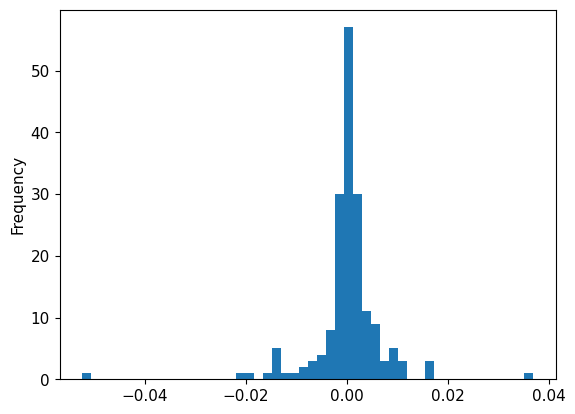

In [31]:
%matplotlib inline
df.confidence.plot.hist(bins=50)


In [27]:
ts_df

,x1,y1,x2,y2,confidence,class
40684101_a2514f39ba853391e5248ab18f36945e.jpg,0.750305,0.168460,0.794835,0.256082,0.921667,1
40770611_377da70ea6314b41640ed9e8b205a8bc.jpg,0.798404,0.200193,0.840102,0.256177,0.833622,1
41692563_936638af3dc4ca9aa5068142f69b2191.jpg,0.720993,0.132055,0.759372,0.235906,0.866831,1
41714241_34cf842e15b2a7a67cca5f0c6cc87d83.jpg,0.710044,0.137869,0.767480,0.242717,0.919222,1
41692583_89a961fc5c3ab4df39c89b4de40b2ef5.jpg,0.720560,0.135742,0.758882,0.235380,0.857673,1
...,...,...,...,...,...,...
p_008645_704203c9623121c81d05700b0dc1a508.jpg,0.405831,0.406266,0.445970,0.511395,0.893926,1
p_008813_a647da3b39845471d5a0d3e4d588bcdc.jpg,0.344295,0.609546,0.437813,0.667865,0.001469,1
p_008828_0ec11fd8bf0fce589b7f25fc6584484e.jpg,0.280063,0.360733,0.374481,0.401561,0.853362,1
p_008560_0bb1291e74636ce14442ff478f390c0e.jpg,0.196991,0.093173,0.240565,0.190443,0.590756,1
